# Neural Style Transfer

Research Paper link: https://arxiv.org/pdf/1508.06576.pdf

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL

from tensorflow.keras import Model

### Gram Matrix

In [2]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    shape = tf.shape(input_tensor)
    i_j = tf.cast(shape[1]*shape[2], tf.float32)
    return gram_matrix/i_j

In [3]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top=False)
    vgg.trainable = False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content = vgg.get_layer(content_layers[0]).output
    styles = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    gram_style_output = [gram_matrix(output_) for output_ in styles]
    
    model = Model([vgg.input], [content, gram_style_output])
    return model

### Data Processing

In [4]:
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

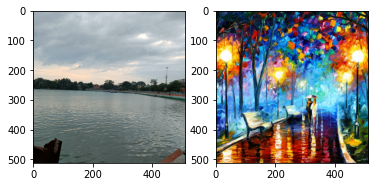

In [5]:
content_img = crop_square(cv2.imread(os.path.join('content.jpg')), 512)
content_img = tf.image.convert_image_dtype(content_img, tf.float32)
style_img = crop_square(cv2.imread(os.path.join('style.jpg')), 512)
style_img = tf.image.convert_image_dtype(style_img, tf.float32)
plt.subplot(121)
plt.imshow(cv2.cvtColor(np.array(content_img), cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(np.array(style_img), cv2.COLOR_BGR2RGB))
plt.show()

### Model Parameters

In [6]:
optim = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [7]:
def loss_object(style_out, content_out, style_tar, content_tar):
    style_weights = 1e-1
    content_weights = 1e-5
    content_loss = tf.reduce_mean((content_out - content_tar)**2)
    style_loss = tf.add_n([tf.reduce_mean((out - tar)**2) for out, tar in zip(style_out, style_tar)])
    total_loss = content_weights*content_loss + style_weights*style_loss
    return total_loss

In [8]:
vgg_model = load_vgg()
content_tar = vgg_model(np.array([content_img*255]))[0]
style_tar = vgg_model(np.array([style_img*255]))[1]

In [9]:
vgg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

                                                                                                  
 tf.__operators__.getitem_4 (Sl  ()                  0           ['tf.compat.v1.shape_2[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  ()                  0           ['tf.compat.v1.shape_2[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_6 (Sl  ()                  0           ['tf.compat.v1.shape_3[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__oper

                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (1, None, 256, 256)  0          ['tf.expand_dims_2[0][0]',       
                                                                  'tf.cast_2[0][0]']              
                                                                                                  
 tf.math.truediv_3 (TFOpLambda)  (1, None, 512, 512)  0          ['tf.expand_dims_3[0][0]',       
                                                                  'tf.cast_3[0][0]']              
                                                                                                  
 tf.math.truediv_4 (TFOpLambda)  (1, None, 512, 512)  0          ['tf.expand_dims_4[0][0]',       
                                                                  'tf.cast_4[0][0]']              
                                                                                                  
Total para

### Training and Image generation

In [10]:
def train_step(img, epoch):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as tape:
            output = vgg_model(img*255)
            loss = loss_object(output[1], output[0], style_tar, content_tar)

            gradient = tape.gradient(loss, img)
            optim.apply_gradients([(gradient, img)])
            img.assign(tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0))

            if (epoch+1) % 10 == 0:
                tf.print(f"Epoch: {epoch+1} | Loss: {loss}")
                plt.imshow(cv2.cvtColor(np.array(img*255, dtype=np.uint8)[0], cv2.COLOR_BGR2RGB))
                plt.show()

Epoch: 10 | Loss: 13067533312.0


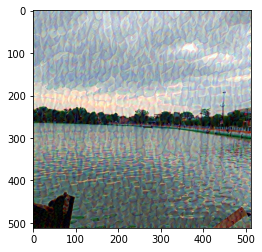

Epoch: 20 | Loss: 7717661184.0


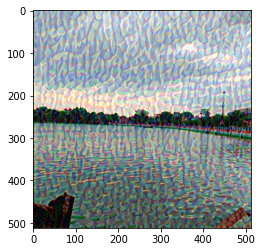

Epoch: 30 | Loss: 6809581056.0


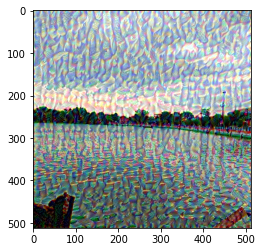

Epoch: 40 | Loss: 4552798720.0


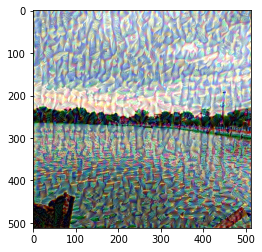

Epoch: 50 | Loss: 3361881344.0


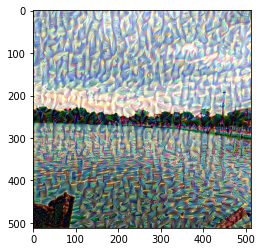

Epoch: 60 | Loss: 2905107712.0


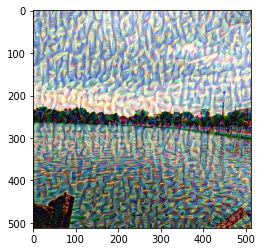

Epoch: 70 | Loss: 2589708032.0


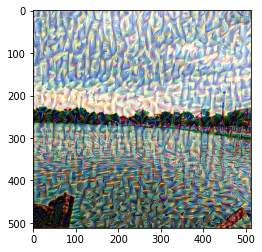

Epoch: 80 | Loss: 2289734912.0


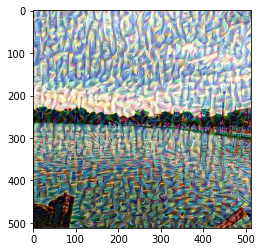

Epoch: 90 | Loss: 2038420480.0


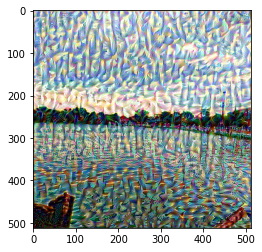

Epoch: 100 | Loss: 1809636992.0


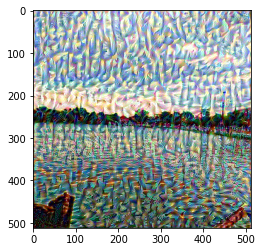

Epoch: 110 | Loss: 1592574464.0


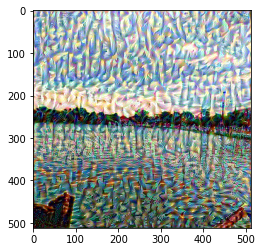

Epoch: 120 | Loss: 1407425792.0


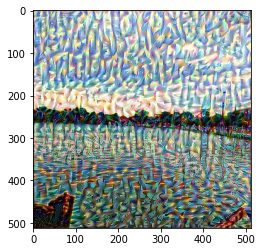

Epoch: 130 | Loss: 1258105728.0


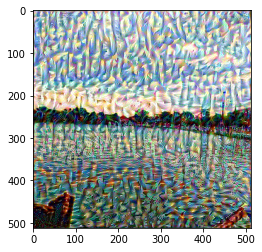

Epoch: 140 | Loss: 1132418560.0


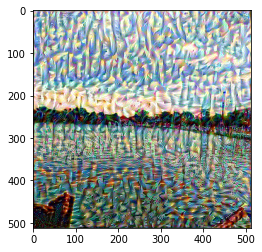

Epoch: 150 | Loss: 1024000704.0


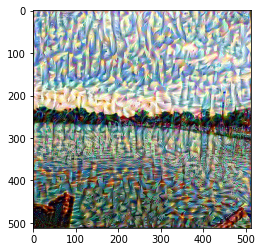

Epoch: 160 | Loss: 922825344.0


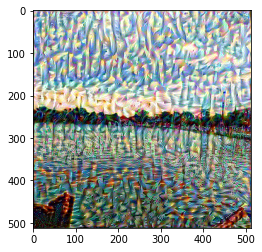

Epoch: 170 | Loss: 834635520.0


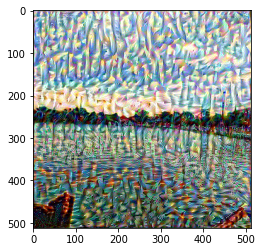

Epoch: 180 | Loss: 755531904.0


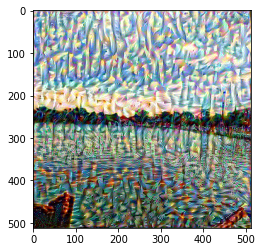

Epoch: 190 | Loss: 686745280.0


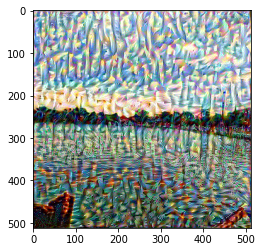

Epoch: 200 | Loss: 628084736.0


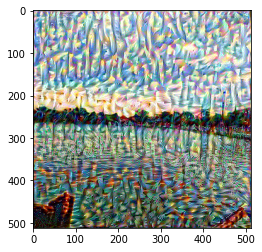

In [11]:
epochs = 200
img = tf.image.convert_image_dtype(content_img, tf.float32)
img = tf.Variable([img])
for i in range(epochs):
    train_step(img, i)

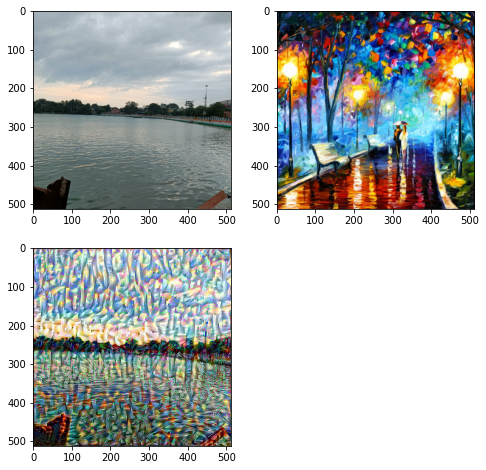

In [12]:
import PIL
tensor = img*255
tensor = np.array(tensor, dtype=np.uint8)

if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
tensor = PIL.Image.fromarray(tensor)
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(cv2.cvtColor(np.array(content_img), cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.imshow(cv2.cvtColor(np.array(style_img), cv2.COLOR_BGR2RGB))
plt.subplot(223)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
cv2.imwrite('Result.jpg', np.array(tensor))

True